Imports + paths

In [22]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pipeline import run_pipeline  # YOUR existing code, unchanged

# ---- output folders ----
OUT_DIR = "sim_outputs"
FIG_DIR = os.path.join(OUT_DIR, "figures")
NPY_DIR = os.path.join(OUT_DIR, "npy")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(NPY_DIR, exist_ok=True)

print("Folders ready:", OUT_DIR)

Folders ready: sim_outputs


Utility functions (Gaussian peaks + rotations)

In [23]:
def make_gaussian_peak(shape, cy, cx, sigma=2.0, amp=100.0):
    ky, kx = shape
    y, x = np.ogrid[:ky, :kx]
    return amp * np.exp(-((y - cy)**2 + (x - cx)**2) / (2 * sigma**2)).astype(np.float32)

def rotate_points(points_xy, angle_rad):
    """
    points_xy: (N,2) with (x,y) coordinates
    returns rotated points (N,2) (x',y')
    """
    R = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                  [np.sin(angle_rad),  np.cos(angle_rad)]], dtype=np.float32)
    return points_xy @ R.T

Synthetic 4D-STEM generator (matrix / coherent / incoherent)

In [24]:
def synth_4dstem(
    ny=128, nx=128, ky=128, kx=128,
    n_precip=10, precip_radius=9,
    case="incoherent",          # "matrix", "coherent", "incoherent"
    seed=0,
    dose=2e5,                   # higher = less noisy
    base_spot_amp=35.0,
    center_amp=200.0,
    base_sigma=1.6,
    coherent_strength=0.25,      # smaller = harder
    incoherent_strength=1.0      # larger = easier
):
    rng = np.random.default_rng(seed)

    data4d = np.zeros((ny, nx, ky, kx), dtype=np.float32)
    mask = np.zeros((ny, nx), dtype=np.uint8)

    # Precipitate centers in scan space
    centers = np.stack([
        rng.integers(low=10, high=ny-10, size=n_precip),
        rng.integers(low=10, high=nx-10, size=n_precip)
    ], axis=1)  # (n_precip, 2) = (cy, cx)

    # Build GT mask
    yy, xx = np.ogrid[:ny, :nx]
    for (cy, cx) in centers:
        mask |= (((yy - cy)**2 + (xx - cx)**2) <= precip_radius**2).astype(np.uint8)
    # ---- FIX: matrix case should have no precipitates ----
    if case == "matrix":
        mask[:] = 0

    # Base spot locations around center in diffraction space
    # Use (x,y) convention for point list
    base_pts = np.array([
        [ 18,   0], [-18,   0],
        [  0,  18], [  0, -18],
        [ 13,  13], [-13, -13],
        [ 13, -13], [-13,  13],
    ], dtype=np.float32)

    # "Incoherent" extra spots: different set
    extra_pts = np.array([
        [ 26,   0], [-26,   0],
        [  0,  26], [  0, -26],
        [ 18,  18], [-18, -18],
        [ 18, -18], [-18,  18],
    ], dtype=np.float32)

    # Scan-dependent orientation field (mimics domains)
    ylin = np.linspace(-1, 1, ny)[:, None]
    xlin = np.linspace(-1, 1, nx)[None, :]
    ang_field = 0.8 * (0.6 * xlin + 0.4 * ylin)   # radians-ish

    # Scan-dependent thickness field (affects intensity)
    thick_field = 0.85 + 0.3 * ((xlin + 1)/2.0 + 0*ylin)  # shape (ny, nx)     # 0.85..1.15

    # Diffraction center
    dcy, dcx = ky // 2, kx // 2

    # Helper: add spot list to pattern
    def add_spots(dp, pts_xy, angle, amp_scale):
        pts = rotate_points(pts_xy, angle)
        for px, py in pts:  # (x,y)
            dp += make_gaussian_peak((ky, kx), dcy + py, dcx + px, sigma=base_sigma, amp=amp_scale)
        return dp

    for j in range(ny):
        for i in range(nx):
            angle = float(ang_field[j, i])
            tscale = float(thick_field[j, i])

            dp = np.zeros((ky, kx), dtype=np.float32)

            # central beam + base spots (matrix everywhere)
            dp += make_gaussian_peak((ky, kx), dcy, dcx, sigma=2.0, amp=center_amp * tscale)
            dp = add_spots(dp, base_pts, angle, amp_scale=base_spot_amp * tscale)

            inside = (mask[j, i] == 1)

            # Apply precipitate physics per case
            if case == "matrix":
                pass  # no additional signal anywhere

            elif case == "coherent":
                # subtle changes: slightly more diffuse halo + weak extra spots
                if inside:
                    # diffuse ring-ish halo (very mild)
                    yy_k, xx_k = np.ogrid[:ky, :kx]
                    rr = np.sqrt((yy_k - dcy)**2 + (xx_k - dcx)**2)
                    halo = np.exp(-0.5 * ((rr - 30.0)/6.0)**2).astype(np.float32)
                    dp += halo * (coherent_strength * 20.0) * tscale

                    # weak extra spots
                    dp = add_spots(dp, extra_pts, angle * 0.8, amp_scale=(coherent_strength * base_spot_amp) * tscale)

            elif case == "incoherent":
                # strong extra reflections + stronger diffuse scattering
                if inside:
                    yy_k, xx_k = np.ogrid[:ky, :kx]
                    rr = np.sqrt((yy_k - dcy)**2 + (xx_k - dcx)**2)
                    diffuse = np.exp(-0.5 * ((rr - 35.0)/7.0)**2).astype(np.float32)
                    dp += diffuse * (incoherent_strength * 60.0) * tscale

                    dp = add_spots(dp, extra_pts, angle * 0.6, amp_scale=(incoherent_strength * 1.6 * base_spot_amp) * tscale)

            else:
                raise ValueError("case must be 'matrix', 'coherent', or 'incoherent'")

            # Normalize to probability then apply Poisson dose
            dp = np.clip(dp, 0, None)
            dp = dp / (dp.sum() + 1e-12)

            # Poisson counts
            data4d[j, i] = rng.poisson(dp * dose).astype(np.float32)

    meta = dict(
        ny=ny, nx=nx, ky=ky, kx=kx, n_precip=n_precip,
        precip_radius=precip_radius, case=case, seed=seed, dose=dose,
        coherent_strength=coherent_strength, incoherent_strength=incoherent_strength
    )
    return data4d, mask, meta

Quick sanity plots (mask + mean DP)

data4d: (128, 128, 128, 128) float32
mask : (128, 128) uint8 precip frac: 0.14068603515625
meta : {'ny': 128, 'nx': 128, 'ky': 128, 'kx': 128, 'n_precip': 10, 'precip_radius': 9, 'case': 'incoherent', 'seed': 0, 'dose': 200000.0, 'coherent_strength': 0.25, 'incoherent_strength': 1.0}


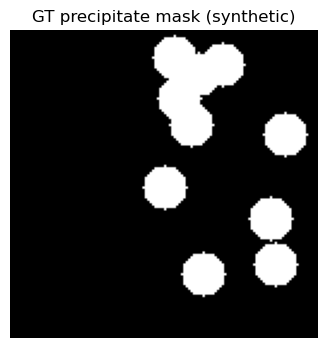

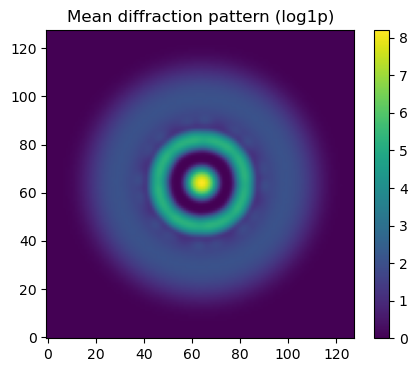

In [25]:
# Generate one dataset for sanity check
data4d_sim, mask_gt, meta = synth_4dstem(case="incoherent", seed=0, dose=2e5)

print("data4d:", data4d_sim.shape, data4d_sim.dtype)
print("mask :", mask_gt.shape, mask_gt.dtype, "precip frac:", mask_gt.mean())
print("meta :", meta)

plt.figure(figsize=(5,4))
plt.imshow(mask_gt, cmap="gray")
plt.title("GT precipitate mask (synthetic)")
plt.axis("off")
plt.show()

mean_dp = data4d_sim.mean(axis=(0,1))
plt.figure(figsize=(5,4))
plt.imshow(np.log1p(mean_dp), origin="lower")
plt.title("Mean diffraction pattern (log1p)")
plt.colorbar()
plt.show()

# Save
np.save(os.path.join(NPY_DIR, "example_sim_data4d.npy"), data4d_sim.astype(np.float32))
np.save(os.path.join(NPY_DIR, "example_sim_mask.npy"), mask_gt.astype(np.uint8))
with open(os.path.join(OUT_DIR, "example_meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

Metrics + cluster→precip mapping

In [26]:
def compute_metrics(y_pred, y_true):
    """
    y_pred, y_true: (ny,nx) binary {0,1}
    returns dict with tp,fp,fn,tn, precision, recall, f1, iou
    """
    yp = y_pred.reshape(-1).astype(int)
    yt = y_true.reshape(-1).astype(int)

    tp = int(np.sum((yp==1) & (yt==1)))
    fp = int(np.sum((yp==1) & (yt==0)))
    fn = int(np.sum((yp==0) & (yt==1)))
    tn = int(np.sum((yp==0) & (yt==0)))

    precision = tp / (tp + fp + 1e-12)
    recall    = tp / (tp + fn + 1e-12)
    f1        = 2*precision*recall / (precision + recall + 1e-12)
    iou       = tp / (tp + fp + fn + 1e-12)

    return dict(tp=tp, fp=fp, fn=fn, tn=tn,
                precision=float(precision), recall=float(recall),
                f1=float(f1), iou=float(iou))

def map_cluster_to_precip(labels, mask_gt):
    """
    labels: (ny,nx) integer cluster labels
    mask_gt: (ny,nx) {0,1}
    choose precip cluster as the cluster with highest GT fraction
    returns precip_cluster_id, y_pred binary mask
    """
    lab = labels.reshape(-1)
    ygt = mask_gt.reshape(-1).astype(int)
    classes = np.unique(lab)

    fracs = [ygt[lab==c].mean() if np.any(lab==c) else 0.0 for c in classes]
    precip_cluster = int(classes[int(np.argmax(fracs))])

    y_pred = (labels == precip_cluster).astype(int)
    return precip_cluster, fracs, y_pred

One full B+D run (with plots)

Cluster precip fractions: [0.0, 1.0] => precip_cluster: 1
Metrics: {'tp': 2305, 'fp': 0, 'fn': 0, 'tn': 14079, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'iou': 1.0}


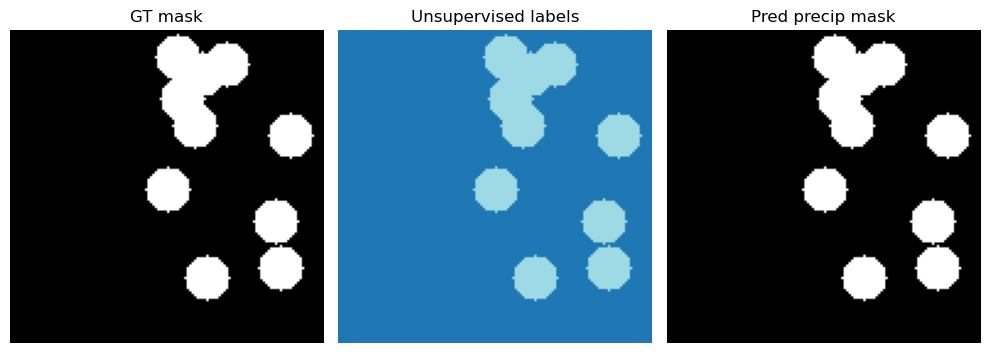

In [27]:
# Run your SAME pipeline on the synthetic dataset
out = run_pipeline(
    data4d_sim,
    nbins=20,
    method="kmeans",   # or "gmm"
    k=2,
    pca_use=5,
    exclude_low_q=0,
    random_state=0
)

labels = out["labels"]
precip_cluster, fracs, y_pred = map_cluster_to_precip(labels, mask_gt)
m = compute_metrics(y_pred, mask_gt)

print("Cluster precip fractions:", fracs, "=> precip_cluster:", precip_cluster)
print("Metrics:", {k: round(v,4) if isinstance(v,float) else v for k,v in m.items()})

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(mask_gt, cmap="gray")
plt.title("GT mask")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(labels, cmap="tab20")
plt.title("Unsupervised labels")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(y_pred, cmap="gray")
plt.title("Pred precip mask")
plt.axis("off")

plt.tight_layout()
plt.show()

# Save key outputs
np.save(os.path.join(NPY_DIR, "labels_example.npy"), labels)
np.save(os.path.join(NPY_DIR, "predmask_example.npy"), y_pred.astype(np.uint8))

Plot cluster radial fingerprints

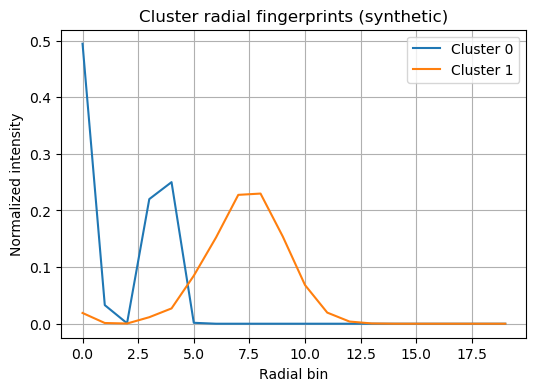

In [28]:
Ximg = out["Xfeat_img"]  # (ny,nx,nbins) radial normalized

nbins = Ximg.shape[-1]
fps = []
for c in np.unique(labels):
    fp = Ximg[labels==c].mean(axis=0)
    fps.append((int(c), fp))

plt.figure(figsize=(6,4))
for c, fp in fps:
    plt.plot(fp, label=f"Cluster {c}")
plt.xlabel("Radial bin")
plt.ylabel("Normalized intensity")
plt.title("Cluster radial fingerprints (synthetic)")
plt.grid(True)
plt.legend()
plt.show()

Sweep study settings

In [29]:
cases = ["matrix", "coherent", "incoherent"]

dose_list = [5e4, 1e5, 2e5, 5e5]    # noise robustness
pca_use_list = [2, 5, 10]           # dimensionality robustness
k_list = [2, 3, 4]                  # over/under segmentation

NBINS = 20
EXCLUDE_LOW_Q = 0
METHOD = "kmeans"  # or "gmm"

SEED = 0
NY, NX, KY, KX = 128, 128, 128, 128

Run sweeps

In [30]:
results = []

for case in cases:
    for dose in dose_list:
        # Generate dataset (same seed so only dose changes noise)
        data4d, mask, meta = synth_4dstem(
            ny=NY, nx=NX, ky=KY, kx=KX,
            case=case, seed=SEED, dose=dose,
            # make coherent actually hard:
            coherent_strength=0.18,
            incoherent_strength=1.0
        )

        for pca_use in pca_use_list:
            for k in k_list:
                out = run_pipeline(
                    data4d,
                    nbins=NBINS,
                    exclude_low_q=EXCLUDE_LOW_Q,
                    method=METHOD,
                    k=k,
                    pca_use=pca_use,
                    random_state=0
                )
                labels = out["labels"]

                # Special rule for "matrix" case: GT mask is all zeros, so detection should ideally be none.
                # Still run mapping; metrics will show false positives if clustering invents precipitates.
                precip_cluster, fracs, y_pred = map_cluster_to_precip(labels, mask)

                metrics = compute_metrics(y_pred, mask)

                results.append(dict(
                    case=case, dose=dose, pca_use=pca_use, k=k,
                    precip_cluster=precip_cluster,
                    frac_list=str([float(x) for x in fracs]),
                    **metrics
                ))

df = pd.DataFrame(results)
df.head()

,case,dose,pca_use,k,precip_cluster,frac_list,tp,fp,fn,tn,precision,recall,f1,iou
0,matrix,50000.0,2,2,0,"[0.0, 0.0]",0,8461,0,7923,0.0,0.0,0.0,0.0
1,matrix,50000.0,2,3,0,"[0.0, 0.0, 0.0]",0,4672,0,11712,0.0,0.0,0.0,0.0
2,matrix,50000.0,2,4,0,"[0.0, 0.0, 0.0, 0.0]",0,4113,0,12271,0.0,0.0,0.0,0.0
3,matrix,50000.0,5,2,0,"[0.0, 0.0]",0,8511,0,7873,0.0,0.0,0.0,0.0
4,matrix,50000.0,5,3,0,"[0.0, 0.0, 0.0]",0,8495,0,7889,0.0,0.0,0.0,0.0


Save results table (CSV)

In [31]:
csv_path = os.path.join(OUT_DIR, "BD_sweep_results.csv")
df.to_csv(csv_path, index=False)
print("Saved:", csv_path)

Saved: sim_outputs\BD_sweep_results.csv


Plot IoU vs dose (coherent vs incoherent) for best k/pca

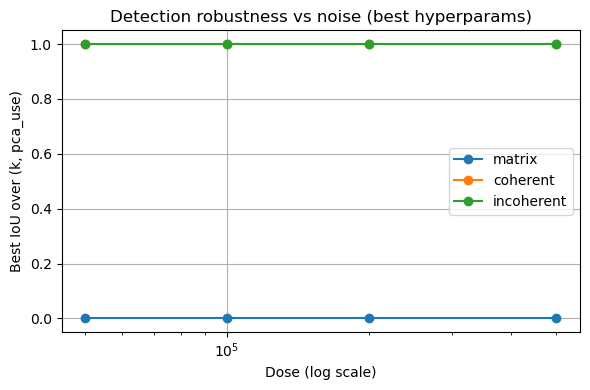

<Figure size 640x480 with 0 Axes>

In [32]:
def best_over_params(df_sub, metric="iou"):
    idx = df_sub[metric].idxmax()
    return df_sub.loc[idx]

summ = []
for case in ["coherent", "incoherent", "matrix"]:
    for dose in dose_list:
        sub = df[(df.case==case) & (df.dose==dose)]
        row = best_over_params(sub, metric="iou")
        summ.append(row.to_dict())   # <-- FIX

df_best = pd.DataFrame(summ)

plt.figure(figsize=(6,4))
for case in ["matrix", "coherent", "incoherent"]:
    dfi = df_best[df_best.case==case].sort_values("dose")
    plt.plot(dfi["dose"], dfi["iou"], marker="o", label=case)

plt.xscale("log")
plt.xlabel("Dose (log scale)")
plt.ylabel("Best IoU over (k, pca_use)")
plt.title("Detection robustness vs noise (best hyperparams)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(FIG_DIR, "IoU_vs_dose_best.png"), dpi=200, bbox_inches="tight")

Plot F1 vs dose too

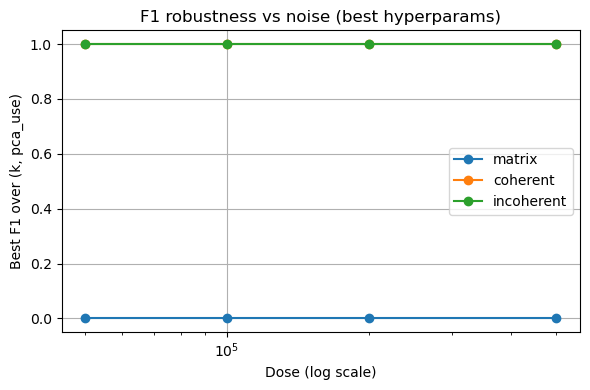

<Figure size 640x480 with 0 Axes>

In [33]:
plt.figure(figsize=(6,4))
for case in ["matrix", "coherent", "incoherent"]:
    dfi = df_best[df_best.case==case].sort_values("dose")
    plt.plot(dfi["dose"], dfi["f1"], marker="o", label=case)

plt.xscale("log")
plt.xlabel("Dose (log scale)")
plt.ylabel("Best F1 over (k, pca_use)")
plt.title("F1 robustness vs noise (best hyperparams)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(FIG_DIR, "F1_vs_dose_best.png"), dpi=200, bbox_inches="tight")

Save one figure set per case for report

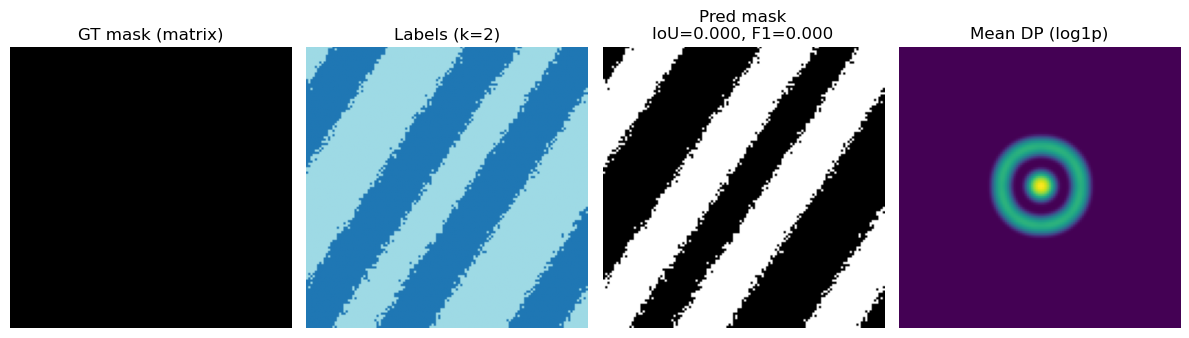

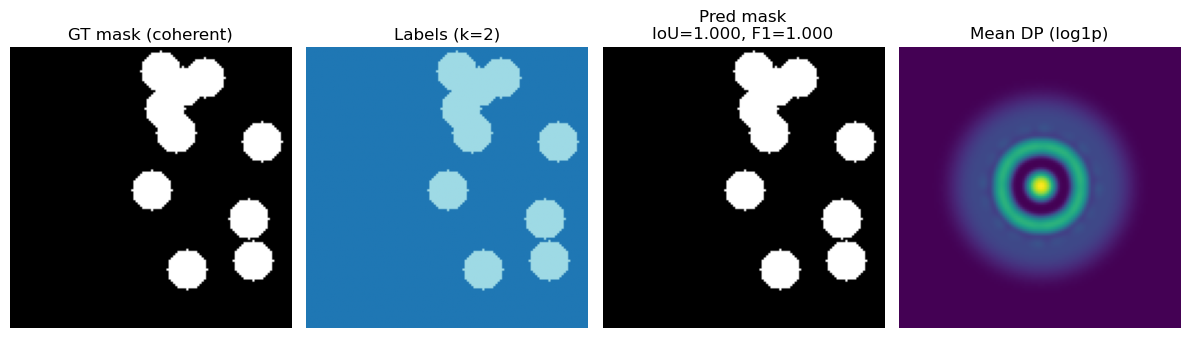

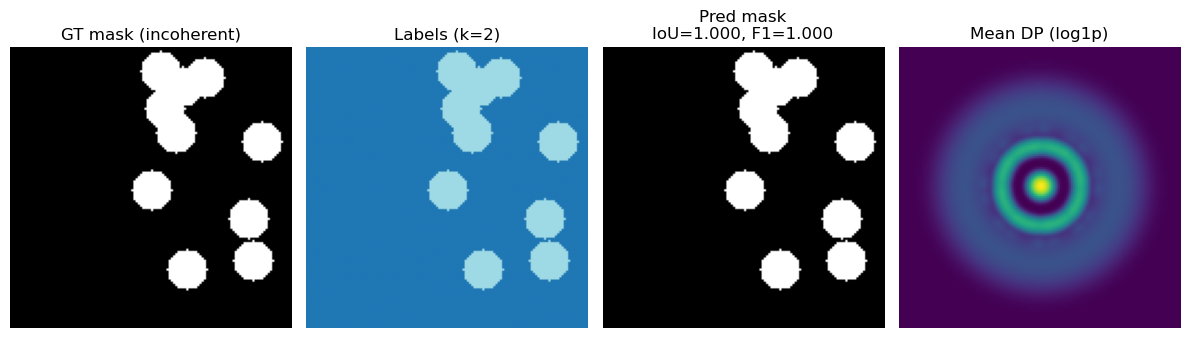

{'case': 'incoherent',
 'dose': 200000.0,
 'k': 2,
 'pca_use': 5,
 'metrics': {'tp': 2305,
  'fp': 0,
  'fn': 0,
  'tn': 14079,
  'precision': 0.9999999999999996,
  'recall': 0.9999999999999996,
  'f1': 0.9999999999994995,
  'iou': 0.9999999999999996},
 'fracs': [0.0, 1.0]}

In [34]:
def save_case_figures(case="coherent", dose=2e5, pca_use=5, k=2):
    data4d, mask, meta = synth_4dstem(
        ny=NY, nx=NX, ky=KY, kx=KX,
        case=case, seed=SEED, dose=dose,
        coherent_strength=0.18,
        incoherent_strength=1.0
    )

    out = run_pipeline(
        data4d,
        nbins=NBINS,
        exclude_low_q=EXCLUDE_LOW_Q,
        method=METHOD,
        k=k,
        pca_use=pca_use,
        random_state=0
    )

    labels = out["labels"]
    precip_cluster, fracs, y_pred = map_cluster_to_precip(labels, mask)
    metrics = compute_metrics(y_pred, mask)

    mean_dp = data4d.mean(axis=(0,1))

    plt.figure(figsize=(12,4))
    plt.subplot(1,4,1)
    plt.imshow(mask, cmap="gray")
    plt.title(f"GT mask ({case})")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(labels, cmap="tab20")
    plt.title(f"Labels (k={k})")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(y_pred, cmap="gray")
    plt.title(f"Pred mask\nIoU={metrics['iou']:.3f}, F1={metrics['f1']:.3f}")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(np.log1p(mean_dp), origin="lower")
    plt.title("Mean DP (log1p)")
    plt.axis("off")

    plt.tight_layout()
    fname = f"summary_{case}_dose{int(dose)}_k{k}_pca{pca_use}.png"
    plt.savefig(os.path.join(FIG_DIR, fname), dpi=220, bbox_inches="tight")
    plt.show()

    return dict(case=case, dose=dose, k=k, pca_use=pca_use, metrics=metrics, fracs=fracs)

# Make a report-ready figure for each case
save_case_figures(case="matrix", dose=2e5, pca_use=5, k=2)
save_case_figures(case="coherent", dose=2e5, pca_use=5, k=2)
save_case_figures(case="incoherent", dose=2e5, pca_use=5, k=2)